## Gender Classification with Perceptron using First Names

In [14]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Read the dataset
df = pd.read_csv("../assets/data/gender.csv")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [17]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [18]:
# Convert each name to feature vector
X = []
y = []

# Considering the last character, unigrams, bigrams, and trigrams in name
num_feats = 26 + 26*26 + 26*26*26 + 1  # 26 letters + 26*26 bigrams + 26*26*26 trigrams + 1 bias = 18279 features

for i in range(len(df)):
    name = df.iloc[i]['Name']
    target = df.iloc[i]['Target']
    name = name.lower()

    vec = np.zeros(num_feats)
    vec[num_feats-1] = 1   # Initialize bias term as 1

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for j in range(len(name)-1):
        bigram = name[j:j+2]
        index = 26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)
        vec[index] += 1

    # Consider all trigrams
    for k in range(len(name)-2):
        trigram = name[k:k+3]
        index = 26*26 + (ord(trigram[0]) - 97)*26*26 + (ord(trigram[1]) - 97)*26 + (ord(trigram[2]) - 97)
        vec[index] += 1

    vec = vec.reshape(-1, 1)
    X.append(vec)

    if target == 0:
        # -1 represents girl
        y.append(-1)
    else:
        # 1 represents boy
        y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])


(18279, 1)
1


In [19]:
# Split data into train and test sets
test_size = 0.1

data = list(zip(X, y))

split_index = int(len(data) * (1 - test_size))
train_data = data[:split_index]
test_data = data[split_index:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 1164
Number of test examples: 130


In [20]:
# Defining weights for perceptron
W = np.zeros((num_feats, 1))

In [21]:
def fit(X, y, W, threshold=1000):
    m = X.shape[0]
    missclassifications = []  # List to store missclassifications at each iteration

    num_iterations = 0

    # Continue till labels are classified
    while True:
        miss = 0
        for j in range(m):
            Z = y[j]*(np.dot(W.T, X[j]))
            if (Z[0][0] <= 0):
                W = W + y[j]*X[j]
                miss += 1
        
        missclassifications.append(miss)

        if (num_iterations % 10 == 0):
            print(f"Iteration {num_iterations}: {miss} missclassifications")
            
        num_iterations += 1

        if (miss == 0):
            print(f"Iteration {num_iterations}: Converged!")
            break
            
        if (num_iterations > threshold):
            print("Algorithm did not converge!")
            break
        
    return W, missclassifications

In [22]:
W, missclassifications = fit(X_train, y_train, W)

Iteration 0: 245 missclassifications
Iteration 10: 35 missclassifications
Iteration 20: 15 missclassifications
Iteration 30: 16 missclassifications
Iteration 40: 7 missclassifications
Iteration 50: 5 missclassifications
Iteration 56: Converged!


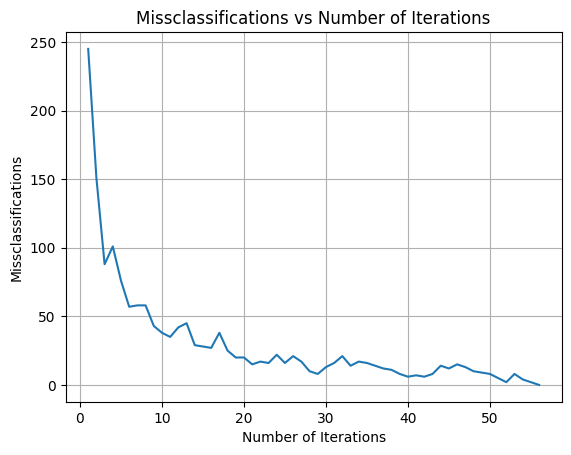

In [23]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(missclassifications) + 1), missclassifications)
plt.xlabel('Number of Iterations')
plt.ylabel('Missclassifications')
plt.title('Missclassifications vs Number of Iterations')
plt.grid(True)
plt.show()

In [24]:
def get_accuracy(X, y, W):

    m = X.shape[0]
    print(f"Total number of test samples: {m}")

    miss = 0
    for j in range(m):
        Z = y[j]*(np.dot(W.T, X[j]))
        if (Z[0][0] <= 0):
            miss += 1
    
    print(f"Number of missclassified samples: {miss}")

    return (m-miss)/m

accuracy = get_accuracy(X_test, y_test, W)
print(f"Accuracy on test set: {accuracy}")

Total number of test samples: 130
Number of missclassified samples: 18
Accuracy on test set: 0.8615384615384616


In [25]:
def predict(test_name):
    # Convert name to feature vector

    name = test_name.lower()
    
    # Considering all unigrams, bigrams, trigrams, and bias term
    num_feats = 703 + 26*26*26  # 26^2 bigrams + 26^3 trigrams + 1 bias term = 18279 features

    vec = np.zeros(num_feats)
    vec[num_feats-1] = 1   # Initialize bias term as 1

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        if not bigram.isalpha() or len(bigram) != 2:
            continue
        vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

    # Consider all trigrams
    for j in range(len(name)-2):
        trigram = name[j:j+3]
        if not trigram.isalpha() or len(trigram) != 3:
            continue
        vec[703 + (ord(trigram[0]) - 97)*26*26 + (ord(trigram[1]) - 97)*26 + (ord(trigram[2]) - 97)] += 1

    vec = vec.reshape(-1, 1)
    
    z = np.dot(W.T, vec)

    if z > 0:
        print("I am sure " + test_name + " is a boy.")
    elif z < 0:
        print("I am sure " + test_name + " is a girl.")
    else:
        print("I am not sure if " + test_name + " is a boy or a girl.")

In [28]:
# Testing with our own example
predict("Chandan")
predict("Chandanbala")

I am sure Chandan is a boy.
I am sure Chandanbala is a girl.
